
===== Test 1: Stable → Drift =====
Drift counts in inference window:
is_drift
1    189
Name: count, dtype: int64


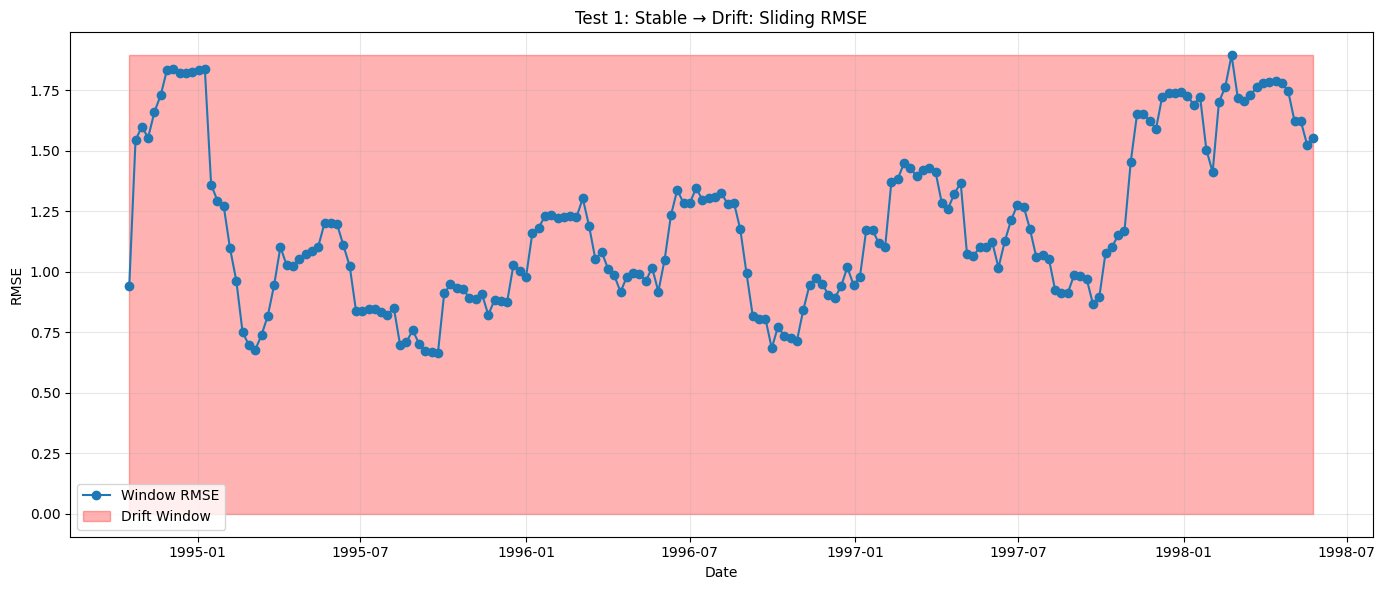

Stable RMSE: nan
Drift RMSE: 1.189
Robustness Ratio (Drift/Stable): nan

===== Test 2: Balanced Mix =====
Drift counts in inference window:
is_drift
0    165
1     94
Name: count, dtype: int64


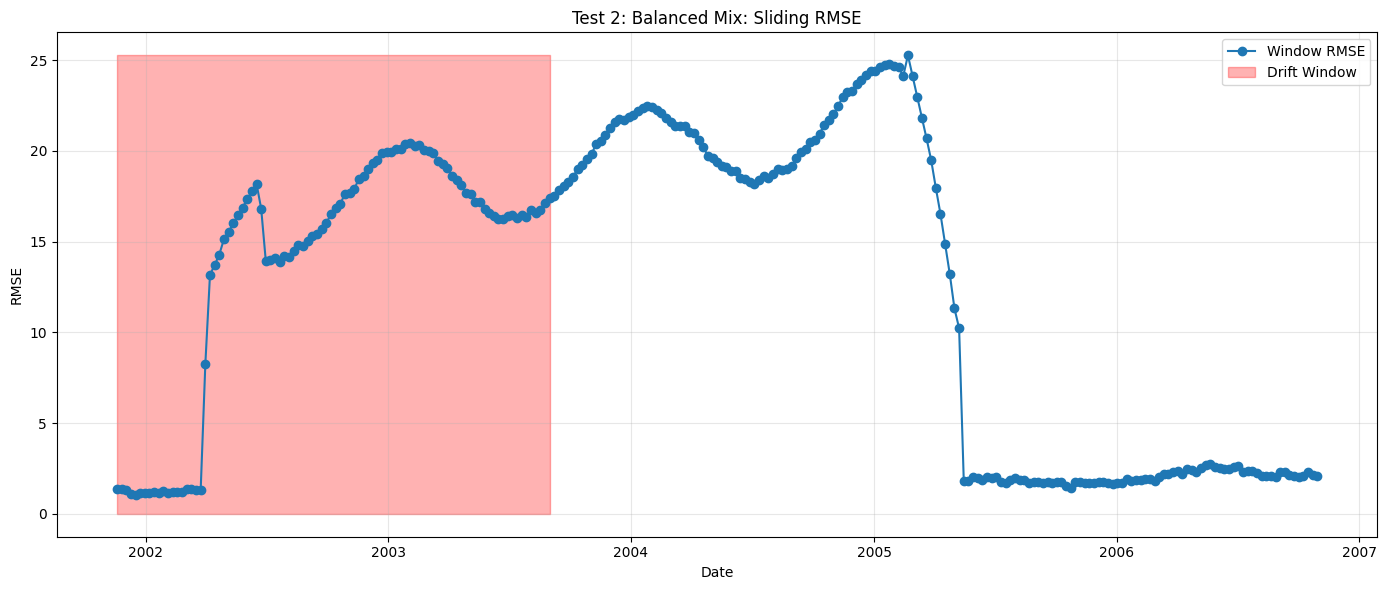

Stable RMSE: 11.899
Drift RMSE: 13.826
Robustness Ratio (Drift/Stable): 1.162

===== Test 3: Long Train, Short Inference =====
Drift counts in inference window:
is_drift
0    89
Name: count, dtype: int64


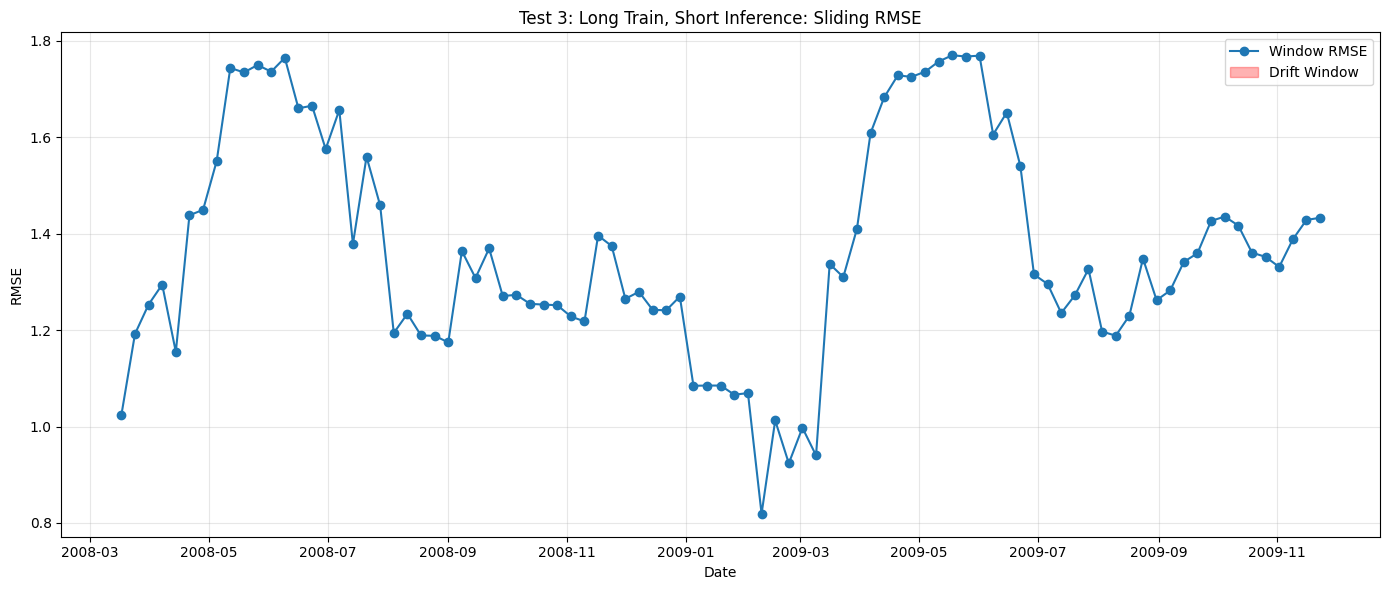

Stable RMSE: 1.366
Drift RMSE: nan
Robustness Ratio (Drift/Stable): nan

===== Test 4: Stable Only → Long Drift =====
Drift counts in inference window:
is_drift
1    139
Name: count, dtype: int64


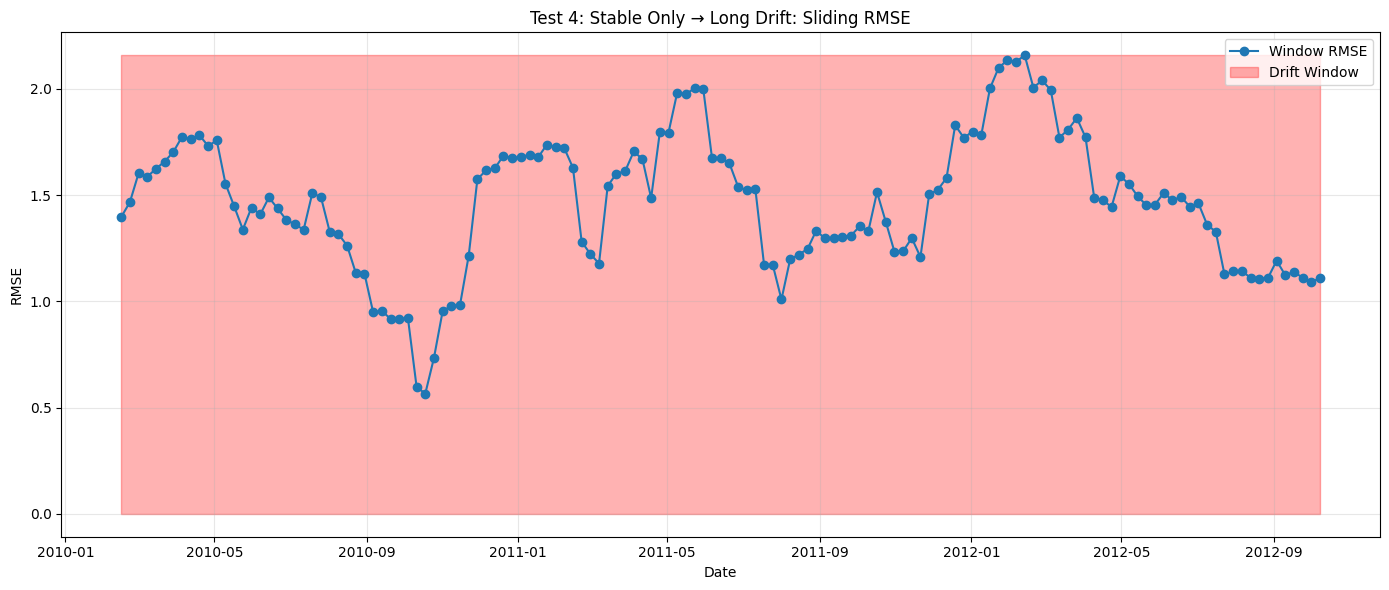

Stable RMSE: nan
Drift RMSE: 1.464
Robustness Ratio (Drift/Stable): nan

===== Test 5: Rolling Regimes =====
Drift counts in inference window:
is_drift
0    152
1    144
Name: count, dtype: int64


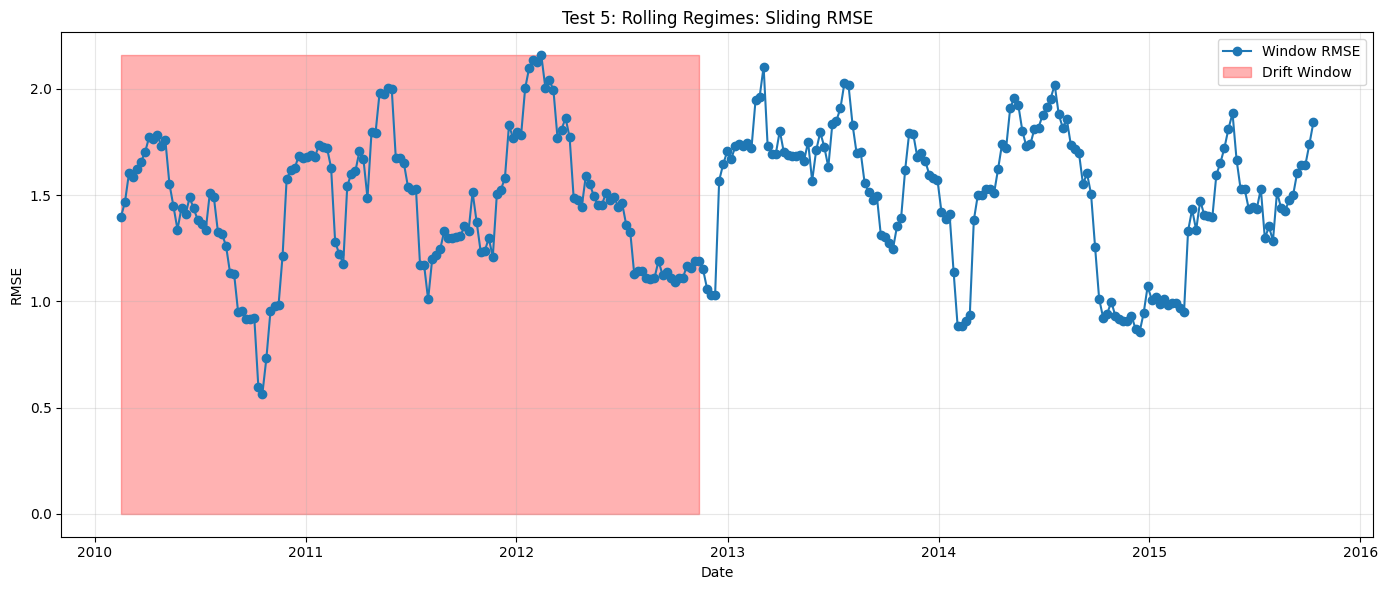

Stable RMSE: 1.503
Drift RMSE: 1.454
Robustness Ratio (Drift/Stable): 0.967


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# === Load & Prepare Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df = df.dropna()

def run_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    # === Define Train/Test Masks ===
    train_df = df[(df.index >= train_start) & (df.index <= train_end)]
    inference_df = df[(df.index >= infer_start) & (df.index <= infer_end)]

    target = 'var1'
    X_train = train_df.drop([target, 'drift_period'], axis=1)
    y_train = train_df[target]

    # === Train Model ===
    model = LinearRegression()
    model.fit(X_train, y_train)

    # === Sliding Window Inference ===
    window_size = 12
    step = 1
    results = []

    for start in range(0, len(inference_df) - window_size + 1, step):
        window = inference_df.iloc[start:start+window_size]
        X_window = window.drop([target, 'drift_period'], axis=1)
        y_window = window[target]
        drift_flag = int(window['drift_period'].mean() > 0.5)

        y_pred = model.predict(X_window)
        rmse = np.sqrt(mean_squared_error(y_window, y_pred))

        results.append({
            'start': window.index[0],
            'end': window.index[-1],
            'rmse': rmse,
            'is_drift': drift_flag
        })

    results_df = pd.DataFrame(results)
    print("Drift counts in inference window:")
    print(results_df['is_drift'].value_counts())

    results_df['start'] = pd.to_datetime(results_df['start'])
    results_df.set_index('start', inplace=True)

    # === Plot RMSE ===
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], marker='o', label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Window')
    plt.title(f'{test_name}: Sliding RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Aggregate Metrics ===
    mean_rmse_drift = results_df[results_df['is_drift'] == 1]['rmse'].mean()
    mean_rmse_stable = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    robustness_ratio = mean_rmse_drift / mean_rmse_stable

    print(f"Stable RMSE: {mean_rmse_stable:.3f}")
    print(f"Drift RMSE: {mean_rmse_drift:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

# === Run 5 Test Cases ===
run_test("Test 1: Stable → Drift",
         "1990-01-01", "1994-10-10",         # stable block 1
         "1994-10-17", "1998-08-10")         # drift block 1

run_test("Test 2: Balanced Mix",
         "1994-10-17", "2001-11-12",         # drift block 1 + stable block 2
         "2001-11-19", "2007-01-15")         # drift block 2 + stable block 3

run_test("Test 3: Long Train, Short Inference",
         "1990-01-01", "2008-03-10",         # all data until end of drift block 3
         "2008-03-17", "2010-02-08")         # stable block 4

run_test("Test 4: Stable Only → Long Drift",
         "1990-01-01", "2010-02-08",         # all stable blocks up to stable block 4
         "2010-02-15", "2012-12-24")         # drift block 4

run_test("Test 5: Rolling Regimes",
         "1990-01-01", "2010-02-08",         # mixed training
         "2010-02-15", "2015-12-28")         # drift block 4 + stable block 5





===== Test 1: Stable → Drift =====
Internal Stable RMSE (from holdout in training): 1.162
Drift counts in inference window:
is_drift
1    189
Name: count, dtype: int64


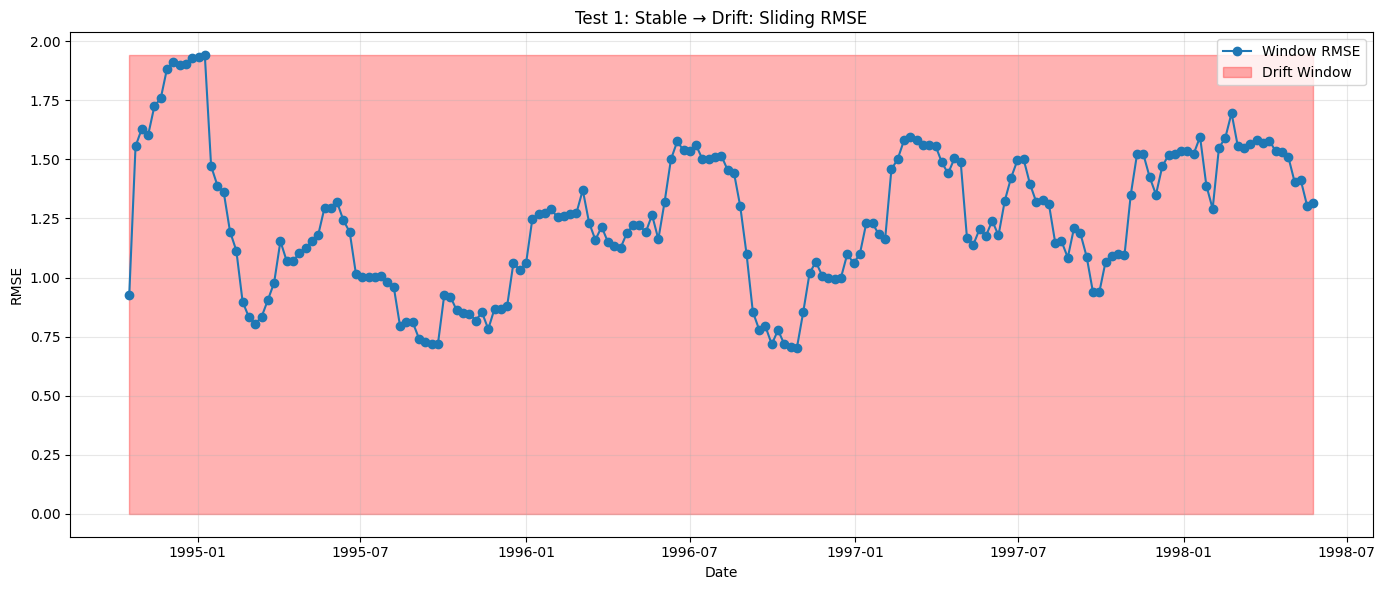

Stable RMSE: 1.162
Drift RMSE: 1.244
Robustness Ratio (Drift/Stable): 1.071

===== Test 2: Balanced Mix =====
Drift counts in inference window:
is_drift
0    165
1     94
Name: count, dtype: int64


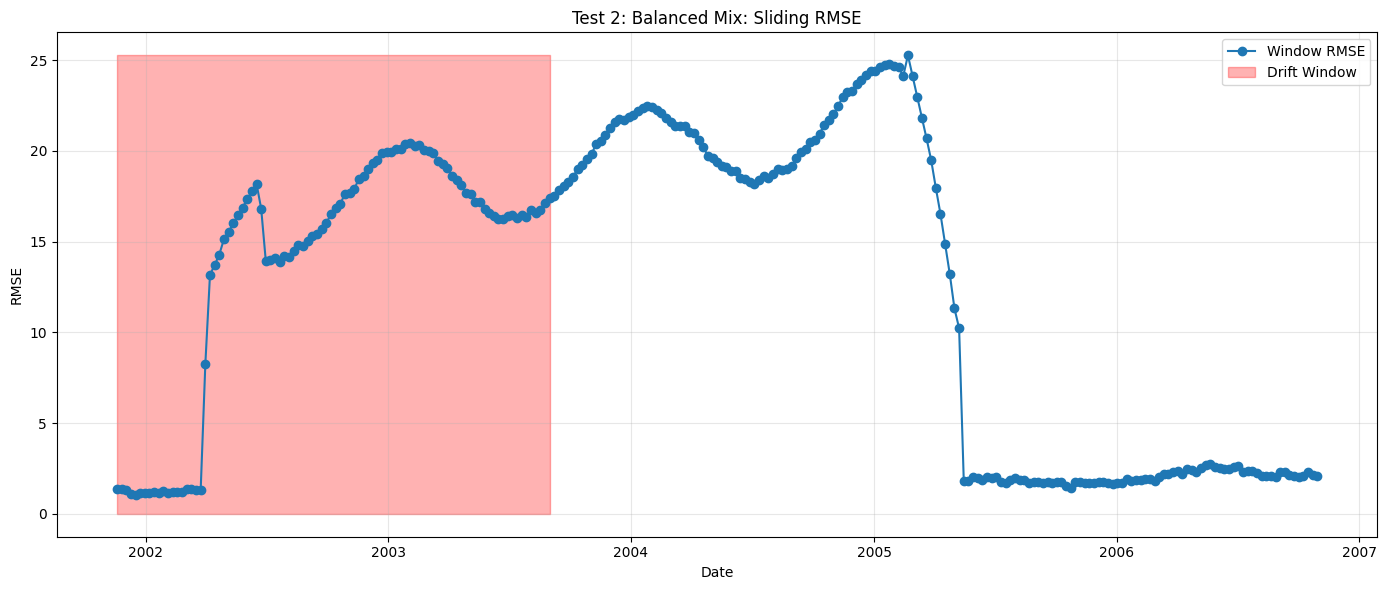

Stable RMSE: 11.899
Drift RMSE: 13.826
Robustness Ratio (Drift/Stable): 1.162

===== Test 3: Long Train, Short Inference =====
Drift counts in inference window:
is_drift
0    89
Name: count, dtype: int64


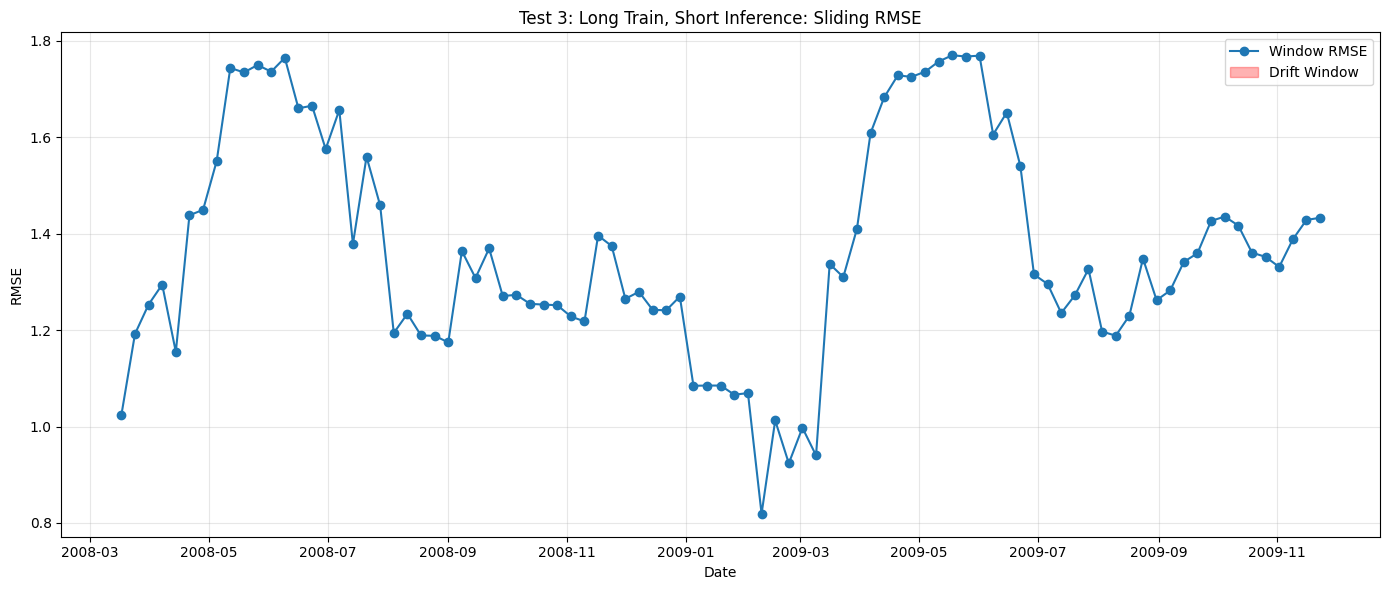

Stable RMSE: 1.366
Drift RMSE: nan
Robustness Ratio (Drift/Stable): nan

===== Test 4: Stable Only → Long Drift =====
Drift counts in inference window:
is_drift
1    139
Name: count, dtype: int64


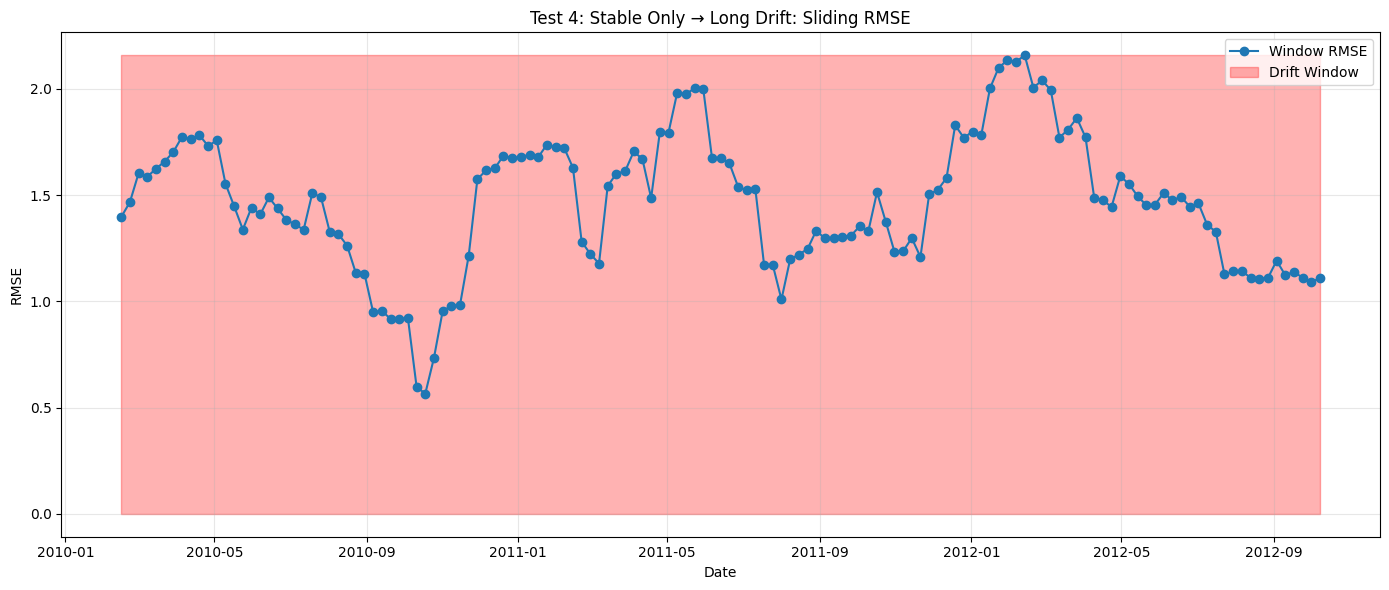

Stable RMSE: nan
Drift RMSE: 1.464
Robustness Ratio (Drift/Stable): nan

===== Test 5: Rolling Regimes =====
Drift counts in inference window:
is_drift
0    152
1    144
Name: count, dtype: int64


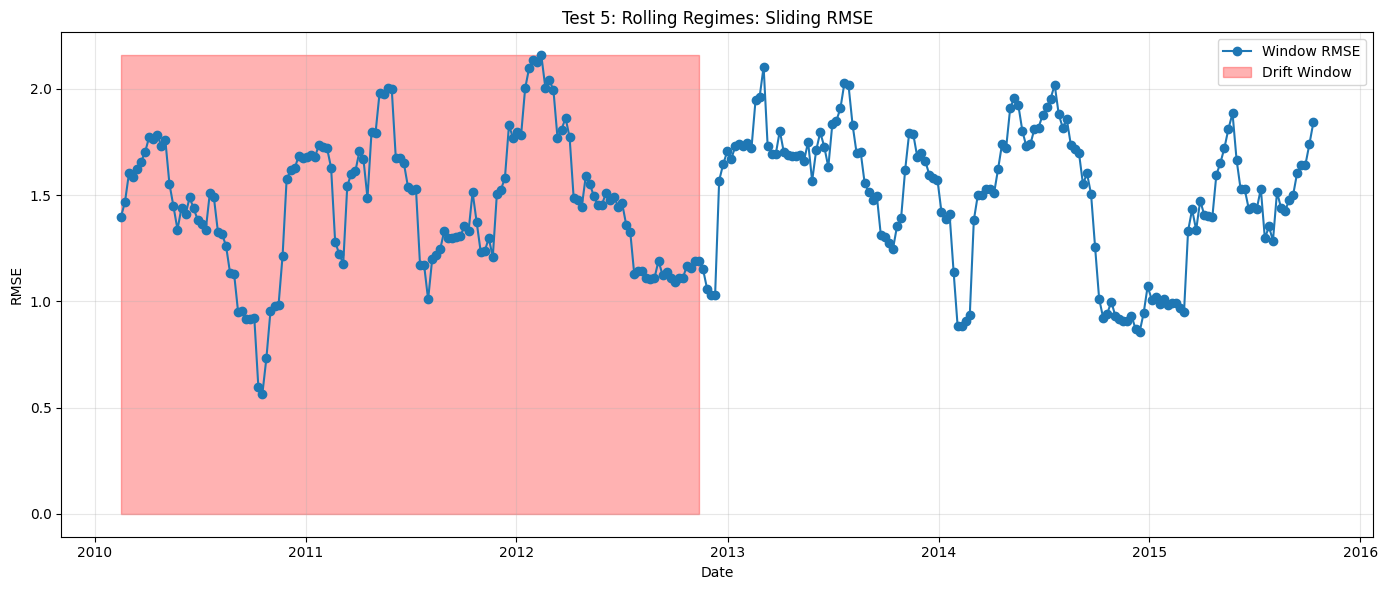

Stable RMSE: 1.503
Drift RMSE: 1.454
Robustness Ratio (Drift/Stable): 0.967


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# === Load & Prepare Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df = df.dropna()

def evaluate_internal_holdout(X_train, y_train, holdout_fraction=0.1):
    n_holdout = int(len(X_train) * holdout_fraction)
    X_main, X_holdout = X_train[:-n_holdout], X_train[-n_holdout:]
    y_main, y_holdout = y_train[:-n_holdout], y_train[-n_holdout:]

    model = LinearRegression()
    model.fit(X_main, y_main)
    y_pred_holdout = model.predict(X_holdout)
    rmse_holdout = np.sqrt(mean_squared_error(y_holdout, y_pred_holdout))
    return model, rmse_holdout

def run_test(test_name, train_start, train_end, infer_start, infer_end, use_internal_eval=False):
    print(f"\n===== {test_name} =====")

    train_df = df[(df.index >= train_start) & (df.index <= train_end)]
    inference_df = df[(df.index >= infer_start) & (df.index <= infer_end)]

    target = 'var1'
    X_train = train_df.drop([target, 'drift_period'], axis=1)
    y_train = train_df[target]

    if use_internal_eval:
        model, internal_rmse = evaluate_internal_holdout(X_train, y_train)
        print(f"Internal Stable RMSE (from holdout in training): {internal_rmse:.3f}")
    else:
        model = LinearRegression()
        model.fit(X_train, y_train)

    # === Sliding Window Inference ===
    window_size = 12
    step = 1
    results = []

    for start in range(0, len(inference_df) - window_size + 1, step):
        window = inference_df.iloc[start:start+window_size]
        X_window = window.drop([target, 'drift_period'], axis=1)
        y_window = window[target]
        drift_flag = int(window['drift_period'].mean() > 0.5)

        y_pred = model.predict(X_window)
        rmse = np.sqrt(mean_squared_error(y_window, y_pred))

        results.append({
            'start': window.index[0],
            'end': window.index[-1],
            'rmse': rmse,
            'is_drift': drift_flag
        })

    results_df = pd.DataFrame(results)
    print("Drift counts in inference window:")
    print(results_df['is_drift'].value_counts())

    results_df['start'] = pd.to_datetime(results_df['start'])
    results_df.set_index('start', inplace=True)

    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], marker='o', label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Window')
    plt.title(f'{test_name}: Sliding RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    mean_rmse_drift = results_df[results_df['is_drift'] == 1]['rmse'].mean()
    mean_rmse_stable = results_df[results_df['is_drift'] == 0]['rmse'].mean()

    if use_internal_eval and np.isnan(mean_rmse_stable):
        mean_rmse_stable = internal_rmse

    robustness_ratio = mean_rmse_drift / mean_rmse_stable if mean_rmse_stable > 0 else float('nan')

    print(f"Stable RMSE: {mean_rmse_stable:.3f}")
    print(f"Drift RMSE: {mean_rmse_drift:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

# === Run Modified Test Cases ===
run_test("Test 1: Stable → Drift", "1990-01-01", "1994-10-10", "1994-10-17", "1998-08-10", use_internal_eval=True)
run_test("Test 2: Balanced Mix", "1994-10-17", "2001-11-12", "2001-11-19", "2007-01-15")
run_test("Test 3: Long Train, Short Inference", "1990-01-01", "2008-03-10", "2008-03-17", "2010-02-08")
run_test("Test 4: Stable Only → Long Drift", "1990-01-01", "2010-02-08", "2010-02-15", "2012-12-24")
run_test("Test 5: Rolling Regimes", "1990-01-01", "2010-02-08", "2010-02-15", "2015-12-28")



===== Test 1: Stable → Drift =====
Drift counts in inference window:
is_drift
1    189
Name: count, dtype: int64


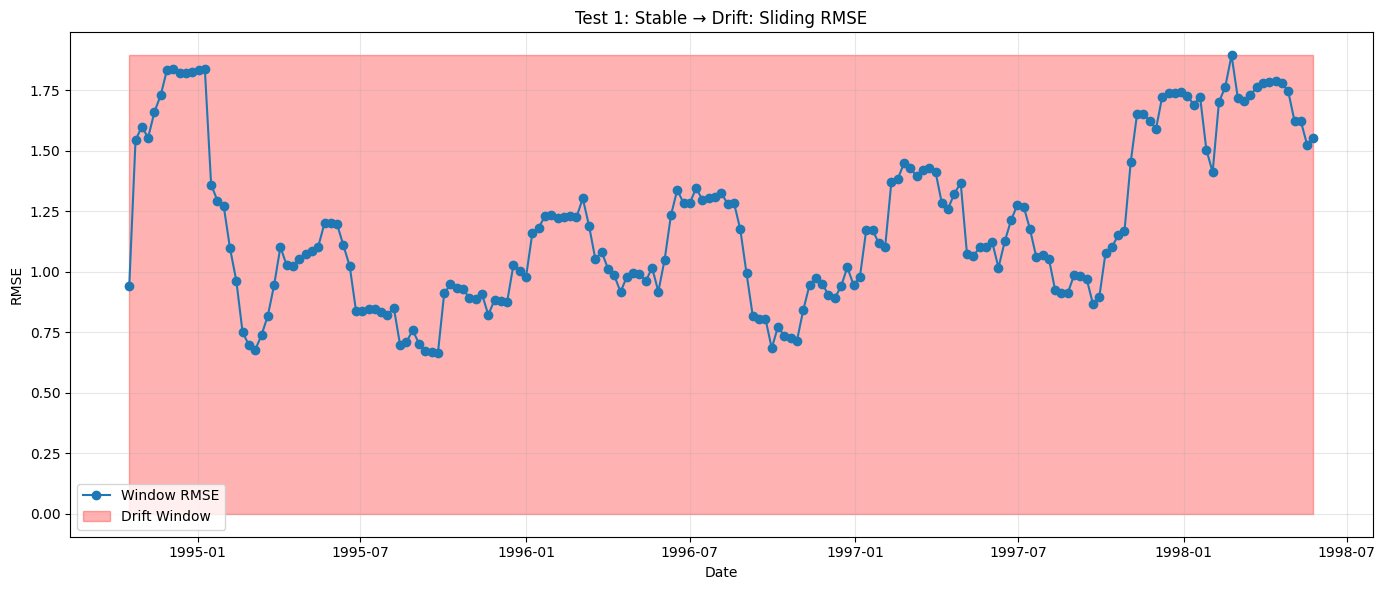

Stable RMSE: 0.932
Drift RMSE: 1.189
Robustness Ratio (Drift/Stable): 1.275

===== Test 2: Balanced Mix =====
Drift counts in inference window:
is_drift
0    165
1     94
Name: count, dtype: int64


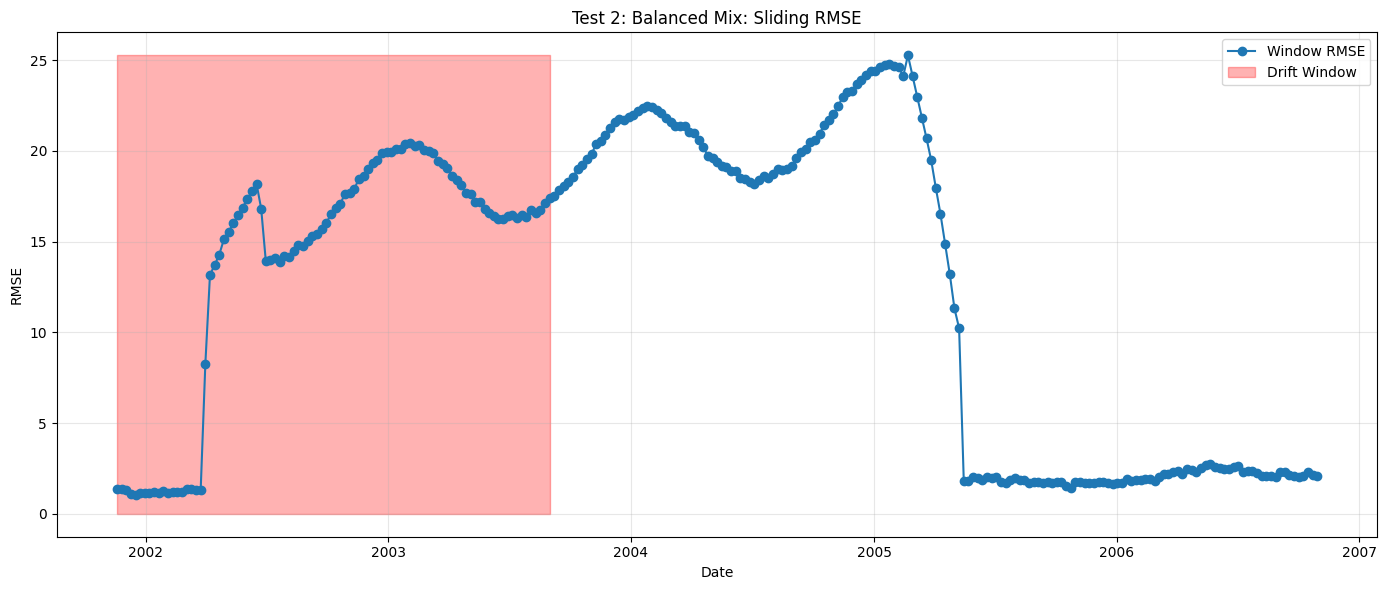

Stable RMSE: 11.899
Drift RMSE: 13.826
Robustness Ratio (Drift/Stable): 1.162

===== Test 3: Long Train, Short Inference =====
Drift counts in inference window:
is_drift
0    89
Name: count, dtype: int64


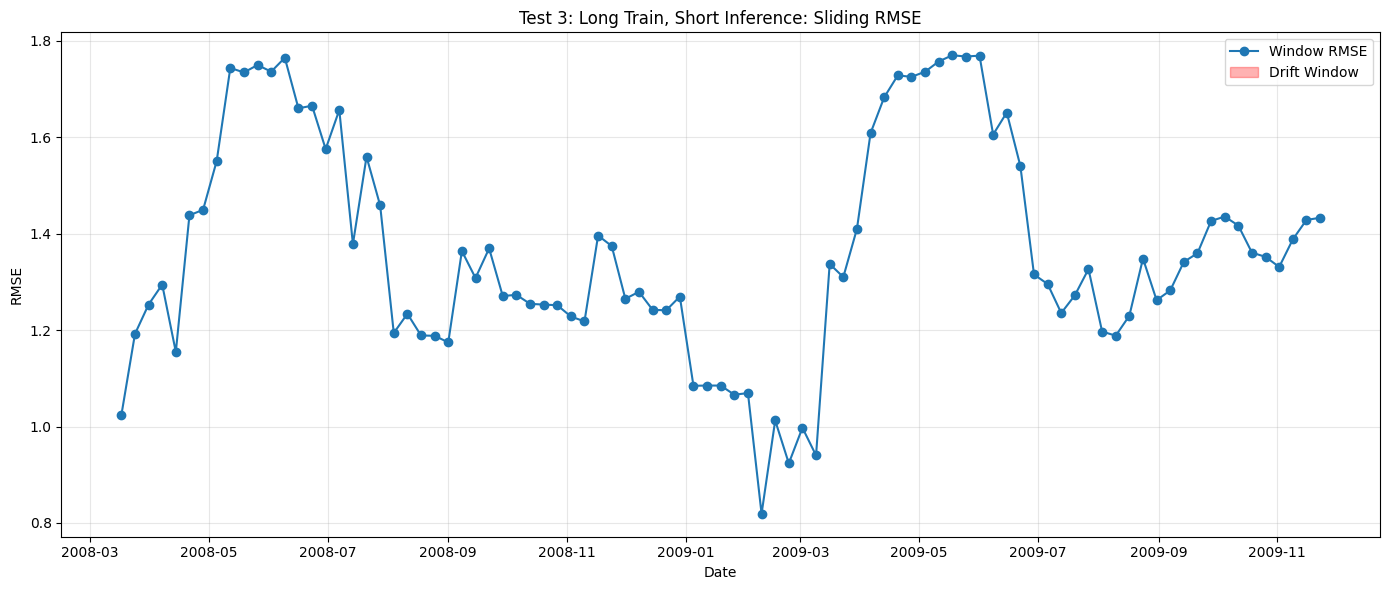

Stable RMSE: 1.366
Drift RMSE: 1.694
Robustness Ratio (Drift/Stable): 1.240

===== Test 4: Stable Only → Long Drift =====
Drift counts in inference window:
is_drift
1    139
Name: count, dtype: int64


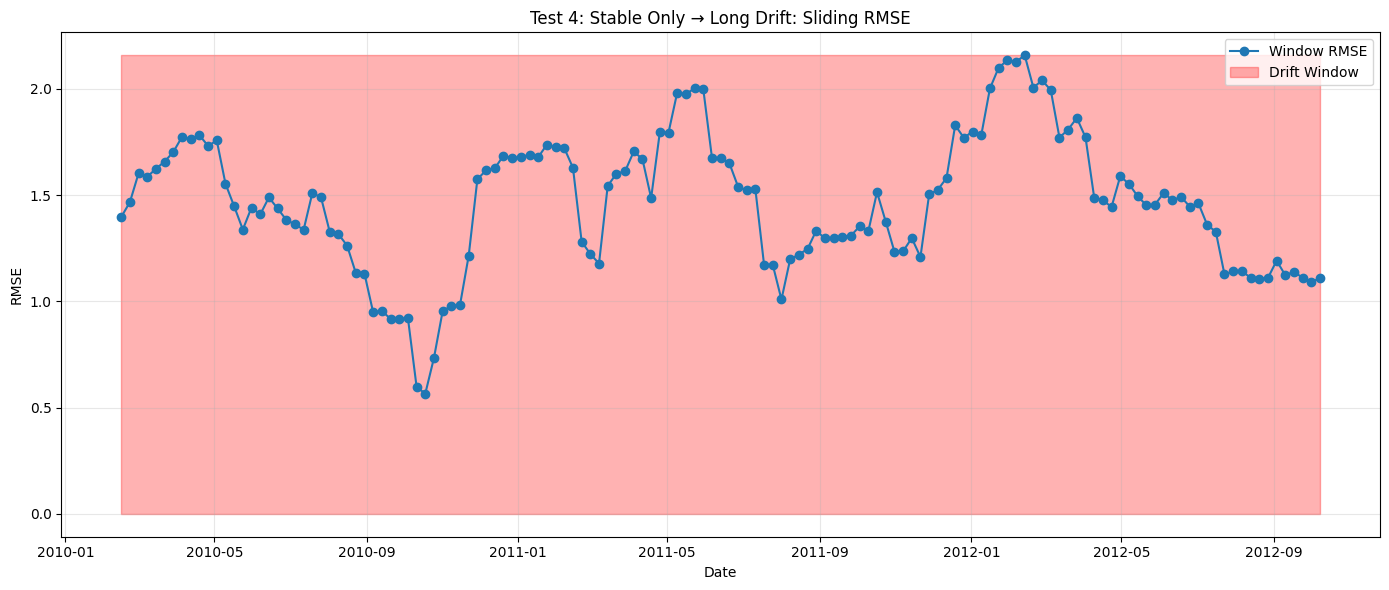

Stable RMSE: 1.206
Drift RMSE: 1.464
Robustness Ratio (Drift/Stable): 1.214

===== Test 5: Rolling Regimes =====
Drift counts in inference window:
is_drift
0    152
1    144
Name: count, dtype: int64


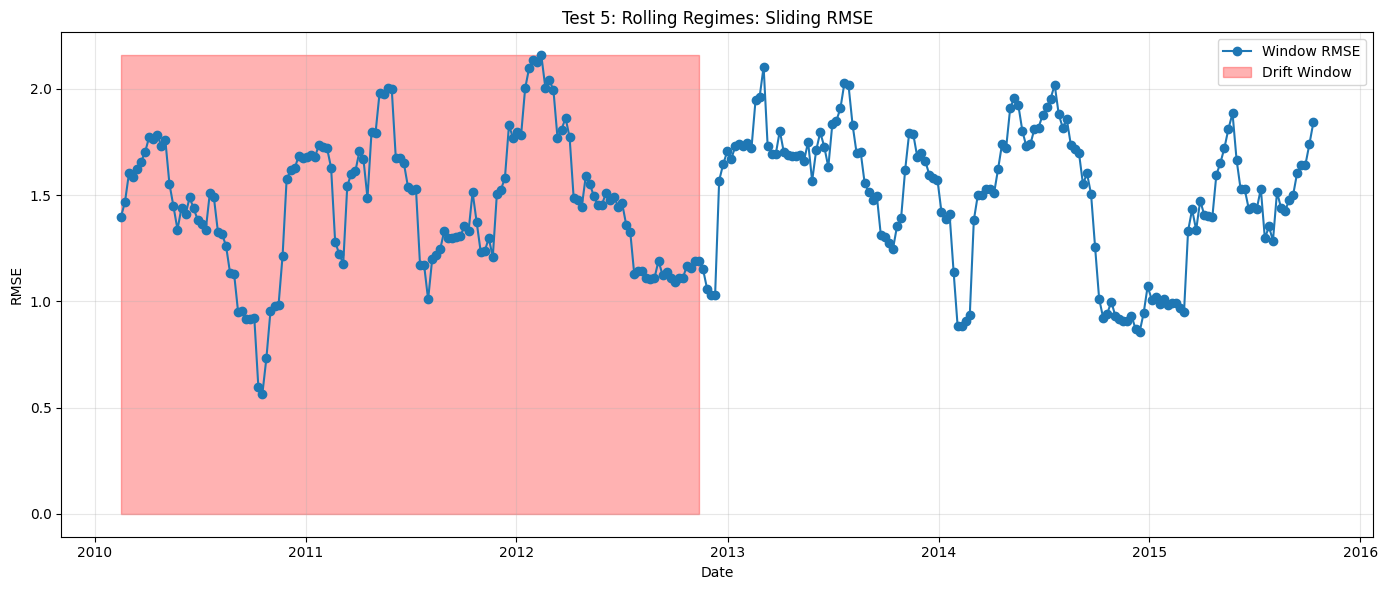

Stable RMSE: 1.503
Drift RMSE: 1.454
Robustness Ratio (Drift/Stable): 0.967


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# === Load & Prepare Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df = df.dropna()

def run_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    # === Define Train/Test Masks ===
    train_df = df[(df.index >= train_start) & (df.index <= train_end)]
    inference_df = df[(df.index >= infer_start) & (df.index <= infer_end)]

    target = 'var1'
    X_train = train_df.drop([target, 'drift_period'], axis=1)
    y_train = train_df[target]

    # === Train Model ===
    model = LinearRegression()
    model.fit(X_train, y_train)

    # === Sliding Window Inference ===
    window_size = 12
    step = 1
    results = []

    for start in range(0, len(inference_df) - window_size + 1, step):
        window = inference_df.iloc[start:start+window_size]
        X_window = window.drop([target, 'drift_period'], axis=1)
        y_window = window[target]
        drift_flag = int(window['drift_period'].mean() > 0.5)

        y_pred = model.predict(X_window)
        rmse = np.sqrt(mean_squared_error(y_window, y_pred))

        results.append({
            'start': window.index[0],
            'end': window.index[-1],
            'rmse': rmse,
            'is_drift': drift_flag
        })

    results_df = pd.DataFrame(results)
    results_df['start'] = pd.to_datetime(results_df['start'])
    results_df.set_index('start', inplace=True)

    print("Drift counts in inference window:")
    print(results_df['is_drift'].value_counts())

    # === Aggregate Metrics ===
    mean_rmse_drift = results_df[results_df['is_drift'] == 1]['rmse'].mean()
    mean_rmse_stable = results_df[results_df['is_drift'] == 0]['rmse'].mean()

    # Fallback to synthetic RMSE from training period if one category is missing
    if np.isnan(mean_rmse_stable):
        stable_windows = train_df[train_df['drift_period'] == 0].iloc[:window_size * 2]  # take first N for stable
        if len(stable_windows) >= window_size:
            y_true = stable_windows[target]
            y_pred = model.predict(stable_windows.drop([target, 'drift_period'], axis=1))
            mean_rmse_stable = np.sqrt(mean_squared_error(y_true, y_pred))

    if np.isnan(mean_rmse_drift):
        drift_windows = train_df[train_df['drift_period'] == 1].iloc[:window_size * 2]  # take first N for drift
        if len(drift_windows) >= window_size:
            y_true = drift_windows[target]
            y_pred = model.predict(drift_windows.drop([target, 'drift_period'], axis=1))
            mean_rmse_drift = np.sqrt(mean_squared_error(y_true, y_pred))

    robustness_ratio = mean_rmse_drift / mean_rmse_stable if mean_rmse_stable > 0 else float('nan')

    # === Plot RMSE ===
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], marker='o', label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Window')
    plt.title(f'{test_name}: Sliding RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stable RMSE: {mean_rmse_stable:.3f}")
    print(f"Drift RMSE: {mean_rmse_drift:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

# === Run 5 Test Cases ===
run_test("Test 1: Stable → Drift",
         "1990-01-01", "1994-10-10",         # stable block 1
         "1994-10-17", "1998-08-10")         # drift block 1

run_test("Test 2: Balanced Mix",
         "1994-10-17", "2001-11-12",         # drift block 1 + stable block 2
         "2001-11-19", "2007-01-15")         # drift block 2 + stable block 3

run_test("Test 3: Long Train, Short Inference",
         "1990-01-01", "2008-03-10",         # all data until end of drift block 3
         "2008-03-17", "2010-02-08")         # stable block 4

run_test("Test 4: Stable Only → Long Drift",
         "1990-01-01", "2010-02-08",         # all stable blocks up to stable block 4
         "2010-02-15", "2012-12-24")         # drift block 4

run_test("Test 5: Rolling Regimes",
         "1990-01-01", "2010-02-08",         # mixed training
         "2010-02-15", "2015-12-28")         # drift block 4 + stable block 5


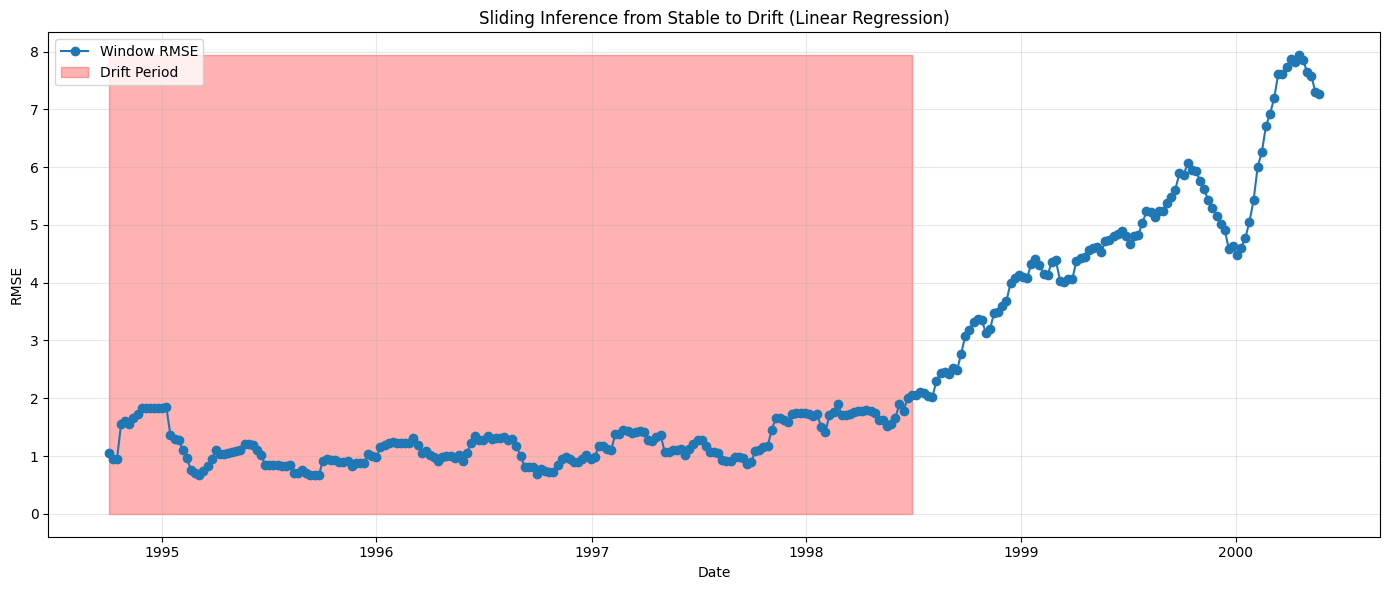

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# === Load Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')

# === Add Time Features & Lags ===
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

# === Train on a Stable Block ===
train_df = df['1990-01-01':'1994-10-10']  # Stable block 1
target = 'var1'
X_train = train_df.drop([target, 'drift_period'], axis=1)
y_train = train_df[target]

model = LinearRegression()
model.fit(X_train, y_train)

# === Sliding Inference from 1994 to 1998 (Stable → Drift Transition) ===
inference_df = df['1994-10-01':'2000-08-10']
window_size = 12
step = 1
results = []

for start in range(0, len(inference_df) - window_size + 1, step):
    window = inference_df.iloc[start:start + window_size]
    X_window = window.drop([target, 'drift_period'], axis=1)
    y_window = window[target]
    drift_flag = int(window['drift_period'].mean() > 0.5)

    y_pred = model.predict(X_window)
    rmse = np.sqrt(mean_squared_error(y_window, y_pred))

    results.append({
        'start': window.index[0],
        'rmse': rmse,
        'is_drift': drift_flag
    })

results_df = pd.DataFrame(results).set_index('start')

# === Plot RMSE vs Time ===
plt.figure(figsize=(14, 6))
plt.plot(results_df.index, results_df['rmse'], marker='o', label='Window RMSE')
plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                 where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Period')
plt.title('Sliding Inference from Stable to Drift (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
